<a href="https://colab.research.google.com/github/godwinrockson/ML_zoomcamp_godwin/blob/main/ML_zoomcamp_hmwk2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Home-price prediction project 

In this project the aim is to use machine learning techniques to build home-price prediction model that can be deployed on a dealer's website such that when potential buyers get to the price and key in various features of the home they want, they are able to see the estimated price of the home.

I use data from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv).

In [300]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [301]:
#Load the data

!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv

--2021-09-20 00:54:52--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7077973 (6.8M) [text/plain]
Saving to: ‘AB_NYC_2019.csv.3’

AB_NYC_2019.csv.3   100%[===================>]   6.75M  --.-KB/s    in 0.09s   

2021-09-20 00:54:52 (78.8 MB/s) - ‘AB_NYC_2019.csv.3’ saved [7077973/7077973]



In [302]:
df = pd.read_csv('AB_NYC_2019.csv')
len(df)

48895

We see there are 48,895 rows of data. 

##Exploratory Data Analysis: Understanding the Data

###1. Cleaning the data
Let's display the first five rows of our data. 

In [303]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


We see that the column names have a uniform partten. Those names that are multi-worded are hyphenated. Still all are lowercase.

However, this is not the case with respect to values of string-valued columns/variables. Let's normalize the values of these non-numerical variables.

In [304]:
string_columns = list(df.dtypes[df.dtypes == 'object'].index) #Select only columns with string values. 

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_') #Lowercase and replace spaces with underscores for values in all string columns of the dataframe

Now take a look at the first five rows again. We have normalized the string column names and values to avoid any confusions.

In [305]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,clean_&_quiet_apt_home_by_the_park,2787,john,brooklyn,kensington,40.64749,-73.97237,private_room,149,1,9,2018-10-19,0.21,6,365
1,2595,skylit_midtown_castle,2845,jennifer,manhattan,midtown,40.75362,-73.98377,entire_home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,the_village_of_harlem....new_york_!,4632,elisabeth,manhattan,harlem,40.80902,-73.94190,private_room,150,3,0,NaN,NaN,1,365
3,3831,cozy_entire_floor_of_brownstone,4869,lisaroxanne,brooklyn,clinton_hill,40.68514,-73.95976,entire_home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,entire_apt:_spacious_studio/loft_by_central_park,7192,laura,manhattan,east_harlem,40.79851,-73.94399,entire_home/apt,80,10,9,2018-11-19,0.10,1,0


###2 Target (dependent) variable  analysis

The first main step in conducting an exploratory data analysis (EDA) is to consider the type snd distribution of the outcome variable to be predicted (being modeled). In this project the target variable is the price, ```price```.

I use histogram to observe the distribution since the values are numerical (integers).

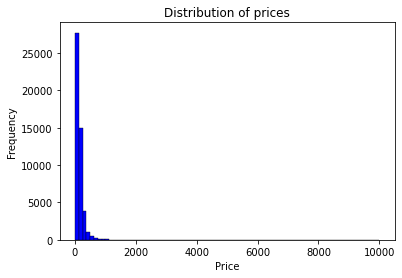

In [306]:
plt.figure(figsize=(6, 4))

sns.histplot(df.price, bins=80, color='blue', alpha=1) #uses histplot function from seaborn
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.ticklabel_format(axis='x', style='plain')
plt.title('Distribution of prices')

plt.show()

Clearly we see the distribution of prices is right-skewed - a long tail a the right. There are numerous cars with very low prices while there are very few cars with extreme prices.

We can plot only prices below $5,000 to see clearly the distribution without the valuesin the tail.

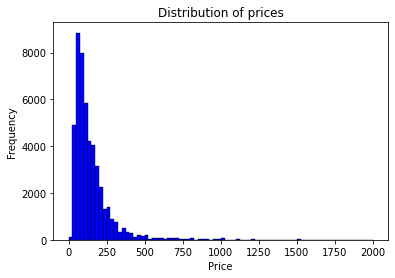

In [307]:
plt.figure(figsize=(6, 4))

sns.histplot(df.price[df.price < 2000], bins=80, color='blue', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

####Target variable transformation

To ensure our model learns the patterns in the data properly, we need to transform the values of the target variable. Applying a log transformation is a popular way to attempt to make the distribution less skewed or even normal/symmetric.

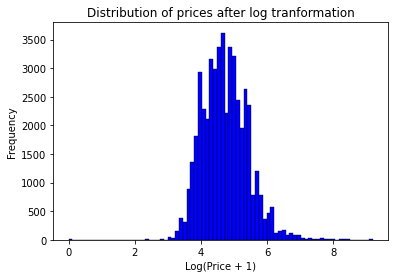

In [308]:
log_price = np.log1p(df.price)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=80, color='blue', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

Though the shape is not completely bell-shape, the long tail has been reduced and now our model can learn the patterns much better.

###3. Chcking for missing values

Another important task in EDA is to know whether there are missing values and how to handle them.

In [309]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

We see that ```name```, ```host_name```, ```last_review``` and ```reviews_per_month``` all have some missing values. However, our target variable, ```price`` has no missing values - a good situation as we do not have to think of handling missing prices.

For this specific project, I will be using the following variables:
* ```latitude```
* ```longitude```
* ```price```
* ```minimum_nights```
* ```number_of_reviews```
* ```reviews_per_month```
* ```calculated_host_listings_count```
* ```availability_365```

So I can select them to a different named dataset.

In [310]:
df1 = df[['latitude',
'longitude',
'price',
'minimum_nights',
'number_of_reviews',
'reviews_per_month',
'calculated_host_listings_count',
'availability_365']]

df1.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,NaN,1,365
3,40.68514,-73.95976,89,1,270,4.64,1,194
4,40.79851,-73.94399,80,10,9,0.10,1,0


In [311]:
df1.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

So in this case, only ```reviews_per_month``` has missing values, totalling 10,052.

Let's take a look at the unique values of each variable and get their sum

In [312]:
for col in df1.columns:
  print(col)
  print(df1[col].unique()[:5]) #first five unique values
  print(df1[col].nunique())
  print()

latitude
[40.64749 40.75362 40.80902 40.68514 40.79851]
19048

longitude
[-73.97237 -73.98377 -73.9419  -73.95976 -73.94399]
14718

price
[149 225 150  89  80]
674

minimum_nights
[ 1  3 10 45  2]
109

number_of_reviews
[  9  45   0 270  74]
394

reviews_per_month
[0.21 0.38  nan 4.64 0.1 ]
937

calculated_host_listings_count
[6 2 1 4 3]
47

availability_365
[365 355 194   0 129]
366



Let's take a look at some summary statistics

In [313]:
df1.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


We can compute these statistics individually for each variable. For example, the median for ```minimum_nights``` is the following:

In [314]:
df1['minimum_nights'].median()

3.0

##Setting up validation Framework

Next we Split the data into validation, training and test sets.

###1. Splitting data into two - 80 : 20 - proportions

The 20% data will be used for validating the model. We will then split the remaining 80 % also into 80 : 20 proportions for training and test sets respectively.

In otherwords, we will split the dataframe such that: 
* 20% of data goes to validation, 
* 20% goes to test, and 
* the remaining 60% goes to train. 

In [315]:
np.random.seed(42)  #Fix the random seed to make sure that the results are reproducible

n = len(df1) #Get the number of rows in the dataframe

n_val = int(0.2 * n) # Calculate how many rows should go to validation. 
n_test = int(0.2 * n) # Calculate how many rows should go to test. 
n_train = n - (n_val + n_test) #Calculate how many rows should go to train. 

idx = np.arange(n) #Create a NumPy array with indices from 0 to (n-1) 
np.random.shuffle(idx) #this randomly shuffles the array created above

df_shuffled = df1.iloc[idx] #Use the array with indices to get a shuffled dataframe

# Below split the shuffled dataframe into train, validation, and test. We make a copy
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

Now we can log-transform our target variable ```price``` for each set.

In [316]:
y_train = np.log1p(df_train.price.values) 
y_val = np.log1p(df_val.price.values) 
y_test = np.log1p(df_test.price.values) 

To be sure we avoid accidentally using the target variable in its original form later in the model building, let’s remove it from the dataframes

In [317]:
del df_train['price'] 
del df_val['price'] 
del df_test['price'] 

## Linear Regression

Next, we start to build a linear regression model to predict the price - using the transformed price.

But before we do that we must deal with the missing values in the ```reviews_per_month``` variable earlier identified.

For this project we will choose from two options: fill it with 0 or with the mean of this variable since we do not want to delete the rows all together.
We will build a model using the two options and later compare the models' RMSE to determine the better option for the dataset.

In [318]:
# Linear Regression using NumPy

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])        #Create an array that contains only 1s. 
    X = np.column_stack([ones, X])    #Add the array of 1s as the first column of X

# normal equation formula
    XTX = X.T.dot(X)                 #XTX is the product of X_Transpose and X
    XTX_inv = np.linalg.inv(XTX)     #Compute the inverse of XTX
    w = XTX_inv.dot(X.T).dot(y)      #The full normal equation
    
    return w[0], w[1:]               # w[0] is the intercept or bias weight and w[1:] is the vector of estimated co-efficients

###Defining our feature (predictor) matrix (X) - Our Independent variables

####1. Using the option of filling missing values with 0

As stated earlier we will use only variables as contained in **```df1```**

As such our X will not contain the log_price variable as y is the log_price variable.

Let's define a selector to help us fast track the creation of X for all three datasets. We will do this by creating a function and will also implement filling missing values with zeroes (0).


In [319]:
base_x = ['latitude',
'longitude',
'minimum_nights',
'number_of_reviews',
'reviews_per_month',
'calculated_host_listings_count',
'availability_365']

In [320]:
def prepare_X(df):
    df_num = df[base_x]           #creates dataframe of selected variables
    df_num = df_num.fillna(0)     #Fills the nans with 0
    X = df_num.values             #convert this dataframe to a NumPy array
    return X

Now let's train the model.

In [321]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)


Let's display our estimated coefficients (weights)


In [322]:
print('Bias (intercept):', '\n', w_0.round(2))
print('\n')
print('Slope coefficients (weights):', '\n', w.round(2))

Bias (intercept): 
 -419.91


Slope coefficients (weights): 
 [ 1.31 -5.02 -0.   -0.   -0.01  0.    0.  ]


Let's predict the price and plot prediction vs actuals

In [323]:
y_pred = w_0 + X_train.dot(w)

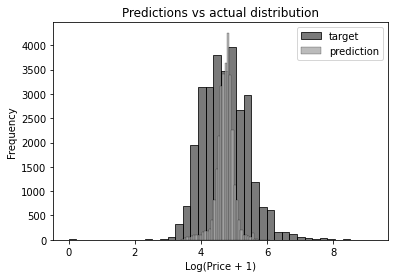

In [324]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

The above plot comparing the distributions of predicted values to the actual shows the predictions are quite off the actuals. 

A common metric used to quantify the quality of models is the Root Mean Square Error (RMSE). The RMSE is a measure of predictive performance of the model. 

Let's define a function to compute this for us. 

In [325]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [326]:
rmse(y_train, y_pred).round(2)      #computes the RMSE

0.64

###Validation

Let's use the validation set to validate out model and compute the RMSE so as to compare with the trained mode. Note that a smaller RMSE means a better model.

Validation is simply applying our model parameters to the validation data (X_val) and then computing the metric.

In [327]:
X_val = prepare_X(df_val)        #remember this prepare_X() fuction was defined earlier to select the features and fill in any missing values with 0.
y_pred = w_0 + X_val.dot(w)      #this the prediction based on the validation data

Apply the rmse function.

In [328]:
rmse(y_val, y_pred).round(2)

0.64

The validation and training data RMSE are quite close.

####2. Using the option of filling missing values with the mean of the column values without the missing values



In [329]:
def prepare_X1(df):
    df_num1 = df[base_x]           #creates dataframe of selected variables
    df_num1 = df_num1.fillna(df_num1.mean())     #Fills the nans with mean
    X1 = df_num1.values             #convert this dataframe to a NumPy array
    return X1

Now let's train the model.

In [330]:
X_train1 = prepare_X1(df_train)
w_01, w1 = train_linear_regression(X_train1, y_train)


Let's display our estimated coefficients (weights)

In [331]:
print('Bias (intercept):', '\n', w_01.round(2))
print('\n')
print('Slope coefficients (weights):', '\n', w1.round(2))

Bias (intercept): 
 -423.54


Slope coefficients (weights): 
 [ 1.31 -5.07 -0.   -0.    0.01  0.    0.  ]


Let's predict the price and plot prediction vs actuals

In [332]:
y_pred1 = w_01 + X_train1.dot(w1)

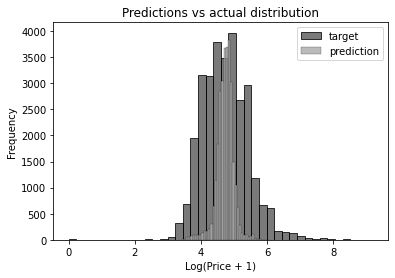

In [333]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred1, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

Compute the RMSE

In [334]:
rmse(y_train, y_pred1).round(2)    #computes the RMSE

0.64

In [335]:
#Validation
X_val1 = prepare_X1(df_val)        #remember this prepare_X1() fuction was defined earlier to select the features and fill in any missing values with the mean.
y_pred1 = w_01 + X_val1.dot(w1)    #this the prediction based on the validation data

Apply the rmse function.

In [336]:
rmse(y_val, y_pred1).round(2) 

0.64

Comparing the RMSE of the models using the data with 0 replacing missing values to the data with missing values replaced by the mean, we can see that both are equally good as the RMSE are quite the same.

##Linear regression with regularization (Ridge regression)

Sometimes, adding more features to our model can help improve the model -- ie., smaller. But some of the added variables may end been linear combination of other columns. This leads to the situation where our XTX matrix becomes singular and cannot be inverted - *numerical instability*. Even where technically invertible, we may have the weights (w) behave abnormally - for example being extremely large.

To avoid this, one option is to use regularized regression. This essentially involves adding a small scaler (number) to the main diagonal of the XTX matrix.

Let's define a new regression function (ridge function) that will incorporate the regularization.


In [337]:
def train_linear_regression_reg(X, y, r=0.0):      #regularization constant r set to 0 as control
    ones = np.ones(X.shape[0])                     #creates a matrix of of ones of shape/length of X
    X = np.column_stack([ones, X])                 #prepares the feature matrix

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])                #creates an Identity matrix of shape/length of X and multiply by the regularization constant r
    XTX = XTX + reg                               #regularized XTX

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

Let's train the model, running a grid search for the r paramter

In [338]:
X_train = prepare_X(df_train)  # remember prepare_X() fills the nans with 0

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print('%9s, %.2f, %.2f, %.2f' % (r, w_0, w[1], w[4]))  #%.2f asks for the values to be printed to two decimal places and %9s says the r should be 8 spaces from the left

        0, -419.91, -5.02, -0.01
    1e-06, -419.86, -5.02, -0.01
   0.0001, -414.98, -4.97, -0.01
    0.001, -375.27, -4.54, -0.01
     0.01, -191.78, -2.54, -0.02
      0.1, -32.56, -0.81, -0.03
        1, -3.50, -0.49, -0.03
        5, -0.70, -0.44, -0.03
       10, -0.35, -0.42, -0.03


The regularization parameter, r = 0.001 seems to be the best. But let's validate the model and compare the RMSEs.

We will start with r = 0, which is the unregularized model.

In [339]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0)   #run the model

y_pred = w_0 + X_train.dot(w)                                 #predict the training model
print('train', rmse(y_train, y_pred))                         #Compute RMSE for the traning model and print result

X_val = prepare_X(df_val)                                  
y_pred = w_0 + X_val.dot(w)                                   #Validate using validation set X to predict
print('val', rmse(y_val, y_pred))                             #Compute RMSE for the validation set and print result


train 0.6428860484860432
val 0.6430337788584176


Now let's run the grid search and compare the rmses

In [340]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred).round(2))

     0 0.64
 1e-06 0.64
0.0001 0.64
 0.001 0.64
  0.01 0.66
   0.1 0.68
     1 0.68
     5 0.68
    10 0.68


Clearly, the model does not improve with r = 0.000001 and r = 0.0001, r = 0.001 compared to r = 0. The model quality even degenerates with r > 0.001

###A Test for model Stability

The data split was done with random seed set at 42. We want to test what happens if we set a different seed value. 

Let's try these values: ```[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]```.

In [341]:

#empty_array = np.array([])
for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
  np.random.seed(s)                                     #Fix the random seed to make sure that the results are reproducible
  n = len(df1)                                             #Get the number of rows in the dataframe 
  n_val2 = int(0.2 * n)                                     # Calculate how many rows should go to validation.
  n_test2 = int(0.2 * n)                                    # Calculate how many rows should go to test.
  n_train2 = n - (n_val2 + n_test2)                           #Calculate how many rows should go to train.
  idx2 = np.arange(n)                                       #Create a NumPy array with indices from 0 to (n-1)
  np.random.shuffle(idx2)                                   #this randomly shuffles the array created above
  df_shuffled2 = df1.iloc[idx2]                              #Use the array with indices to get a shuffled dataframe
  
  # Below split the shuffled dataframe into train, validation, and test. We make a copy
  df_train2 = df_shuffled2.iloc[:n_train2].copy()
  df_val2 = df_shuffled2.iloc[n_train2:n_train2+n_val2].copy()
  df_test2 = df_shuffled2.iloc[n_train2+n_val2:].copy()
  y_train2 = np.log1p(df_train2.price.values)
  y_val2 = np.log1p(df_val2.price.values)
  y_test2 = np.log1p(df_test2.price.values)

  #delete the original price variable
  del df_train2['price'] 
  del df_val2['price'] 
  del df_test2['price']  
  
  #define a function to prepare X
  def prepare_X2(df_2):
    df_num2 = df_2[base_x]           #creates dataframe of selected variables
    df_num2 = df_num2.fillna(0)     #Fills the nans with 0
    X2 = df_num2.values             #convert this dataframe to a NumPy array
    return X2
  #Use the function to prepare X for the three sub dataaets
  X_train2 = prepare_X2(df_train2)
  X_val2 = prepare_X2(df_val2)
  X_test2 = prepare_X2(df_test2)

  #Linear Regression using NumPy
  def train_linear_regression2(X, y):
    ones = np.ones(X.shape[0])        #Create an array that contains only 1s. 
    X = np.column_stack([ones, X])    #Add the array of 1s as the first column of X

  #normal equation formula
    XTX = X.T.dot(X)                 #XTX is the product of X_Transpose and X
    XTX_inv = np.linalg.inv(XTX)     #Compute the inverse of XTX
    w = XTX_inv.dot(X.T).dot(y)      #The full normal equation
    
    return w[0], w[1:]               # w[0] is the intercept or bias weight and w[1:] is the vector of estimated co-efficients

  #Define function to compute RMSE
  def rmse2(y2, y_pred2):
    error = y_pred2 - y2
    mse2 = (error ** 2).mean()
    return np.sqrt(mse2)

  #Train the model, validate and compute the RMSE of the validation
  w_02, w2 = train_linear_regression2(X_train2, y_train2)
  y_pred2 = w_02 + X_val2.dot(w2)
  print('%6s' %s, rmse2(y_val2, y_pred2))
  



     0 0.6549779961157263
     1 0.646252368578719
     2 0.6476558177163445
     3 0.6375145071233626
     4 0.6445809083551755
     5 0.6305809996077186
     6 0.6297851917617103
     7 0.6506184267164312
     8 0.6489780353432693
     9 0.6437565168302604


In [342]:
df_rmse = (0.6549779961157263,0.646252368578719,0.6476558177163445,0.6375145071233626,0.6445809083551755,0.6305809996077186,0.6297851917617103,0.6506184267164312,0.6489780353432693,0.6437565168302604)

Calculate standard deviation

In [343]:
round(np.std(df_rmse),3)



0.008

This is a low standard deviation. This indicates that our model is quite stable.

###Combining the previous train and validation, using regularization parameter of 0.001 and seed = 9

We want to use this combined set as the train data and compute the RMSE for the test data for regularized model.

In [344]:
np.random.seed(9)                                     
n = len(df1)                                             
n_val2 = int(0.2 * n)                                     
n_test2 = int(0.2 * n)                                    
n_train2 = n - (n_val2 + n_test2)                          
idx2 = np.arange(n)                                       
np.random.shuffle(idx2)                                   
df_shuffled2 = df1.iloc[idx2]                              
  
# Below split the shuffled dataframe into train, validation, and test. We make a copy
df_train2 = df_shuffled2.iloc[:n_train2].copy()
df_val2 = df_shuffled2.iloc[n_train2:n_train2+n_val2].copy()
#Define new train data by combining initial train and val
df_train3 = df_train2.append(df_val2)
df_test2 = df_shuffled2.iloc[n_train2+n_val2:].copy()
y_train3 = np.log1p(df_train3.price.values)
#y_val2 = np.log1p(df_val2.price.values)
y_test2 = np.log1p(df_test2.price.values)

#Another way to define new train data
#y_train3 = np.hstack((y_train2, y_val2))

#delete the original price variable
del df_train3['price'] 
del df_test2['price']  
  
#define a function to prepare X
def prepare_X3(df_3):
  df_num3 = df_3[base_x]           #creates dataframe of selected variables
  df_num3 = df_num3.fillna(0)     #Fills the nans with 0
  X3 = df_num3.values             #convert this dataframe to a NumPy array
  return X3
  #Use the function to prepare X for the three sub dataaets
  #We use the 
X_train3 = prepare_X3(df_train3)
X_test2 = prepare_X3(df_test2)

  #Regularized Linear Regression using NumPy
def train_linear_regression_reg3(X, y, r=0.0):      #regularization constant r set to 0 as control
    ones = np.ones(X.shape[0])                     #creates a matrix of of ones of shape/length of X
    X = np.column_stack([ones, X])                 #prepares the feature matrix

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])                #creates an Identity matrix of shape/length of X and multiply by the regularization constant r
    XTX = XTX + reg                               #regularized XTX

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

  #Define function to compute RMSE
def rmse3(y3, y_pred3):
  error = y_pred3 - y3
  mse3 = (error ** 2).mean()
  return np.sqrt(mse3)

  #Train the model, validate and compute the RMSE of the validation
w_03, w3 = train_linear_regression_reg3(X_train3, y_train3, r = 0.001)
y_pred3 = w_03 + X_test2.dot(w3)  #Tests model on test data
rmse3(y_test2, y_pred3).round(2)

0.65

We note that the RMSE is almost about the same as earlier validations.